<h1>Uber Data Predictive Modeling (2017–2020 + Taxi Zones)</h1>

In [3]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import os

# Set folder path
folder = "trips"

# Read all yearly files automatically
files = [f for f in os.listdir(folder) if f.endswith('_trimmed.csv')]
df_list = [pd.read_csv(os.path.join(folder, f)) for f in files]
df = pd.concat(df_list, ignore_index=True)

# Read taxi zone file
zones = pd.read_csv(os.path.join(folder, 'taxi_zones.csv'))

print("✅ Data Loaded Successfully")
print("Total Records:", len(df))
df.head()


✅ Data Loaded Successfully
Total Records: 400000


,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2.0,2017-01-04 18:03:23.000,2017-01-04 18:10:41.000,N,1.0,33,52,1.0,0.96,6.5,1.0,0.5,1.66,0.0,0.3,9.96,1.0,1.0,NaN
1,2.0,2017-02-21 14:36:40.000,2017-02-21 14:44:06.000,N,1.0,25,97,1.0,1.12,6.5,0.0,0.5,2.19,0.0,0.3,9.49,1.0,1.0,NaN
2,2.0,2017-03-09 08:53:53.000,2017-03-09 08:59:02.000,N,1.0,41,166,1.0,0.95,6.0,0.0,0.5,1.36,0.0,0.3,8.16,1.0,1.0,NaN
3,2.0,2017-12-05 20:15:50.000,2017-12-05 20:18:26.000,N,1.0,260,260,5.0,0.55,4.0,0.5,0.5,1.00,0.0,0.3,6.30,1.0,1.0,NaN
4,2.0,2017-07-12 14:45:33.000,2017-07-12 14:50:52.000,N,1.0,17,17,1.0,0.63,5.5,0.0,0.5,0.00,0.0,0.3,6.30,2.0,1.0,NaN


In [4]:
# Merge Pickup Boroughs
df = df.merge(zones[['LocationID', 'Borough']], how='left', left_on='PULocationID', right_on='LocationID')
df = df.rename(columns={'Borough': 'pickup_borough'}).drop('LocationID', axis=1)

# Merge Dropoff Boroughs
df = df.merge(zones[['LocationID', 'Borough']], how='left', left_on='DOLocationID', right_on='LocationID')
df = df.rename(columns={'Borough': 'dropoff_borough'}).drop('LocationID', axis=1)

print("✅ Boroughs added successfully")
df[['PULocationID', 'pickup_borough', 'DOLocationID', 'dropoff_borough']].head()


✅ Boroughs added successfully


,PULocationID,pickup_borough,DOLocationID,dropoff_borough
0,33,Brooklyn,52,Brooklyn
1,25,Brooklyn,97,Brooklyn
2,41,Manhattan,166,Manhattan
3,260,Queens,260,Queens
4,17,Brooklyn,17,Brooklyn


In [6]:
df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'], errors='coerce')

df['year'] = df['lpep_pickup_datetime'].dt.year
df['month'] = df['lpep_pickup_datetime'].dt.month
df['week'] = df['lpep_pickup_datetime'].dt.isocalendar().week
df['hour'] = df['lpep_pickup_datetime'].dt.hour
df['day_of_week'] = df['lpep_pickup_datetime'].dt.day_name()

# Drop null times
df = df.dropna(subset=['lpep_pickup_datetime'])
print("✅ Time features created")


✅ Time features created


In [7]:
# Group by Year and ISO Week
weekly_trips = df.groupby(['year', 'week']).size().reset_index(name='Weekly_Trips')

# Ensure year and week are integers
weekly_trips['year'] = weekly_trips['year'].astype(int)
weekly_trips['week'] = weekly_trips['week'].astype(int)

# Properly create 'week_start' date
weekly_trips['week_start'] = pd.to_datetime(
    weekly_trips['year'].astype(str) + '-' + weekly_trips['week'].astype(str) + '-1',
    format='%Y-%W-%w',
    errors='coerce'
)

# ✅ Filter only valid dates between 2017 and 2020
weekly_trips = weekly_trips[(weekly_trips['week_start'] >= '2017-01-01') & (weekly_trips['week_start'] <= '2020-12-31')]

# Prepare for Prophet
df_prophet = weekly_trips.rename(columns={'week_start': 'ds', 'Weekly_Trips': 'y'})
df_prophet = df_prophet.sort_values('ds')

print(df_prophet.head())
print(df_prophet.tail())


   year  week     y         ds
3  2017     1  1956 2017-01-02
4  2017     2  2170 2017-01-09
5  2017     3  2006 2017-01-16
6  2017     4  2211 2017-01-23
7  2017     5  2262 2017-01-30
     year  week     y         ds
206  2020    48  1057 2020-11-30
207  2020    49  1193 2020-12-07
208  2020    50  1249 2020-12-14
209  2020    51  1053 2020-12-21
210  2020    52   980 2020-12-28


<h1>Weekly Trip Demand Forecasting</h1>

11:14:55 - cmdstanpy - INFO - Chain [1] start processing
11:14:56 - cmdstanpy - INFO - Chain [1] done processing


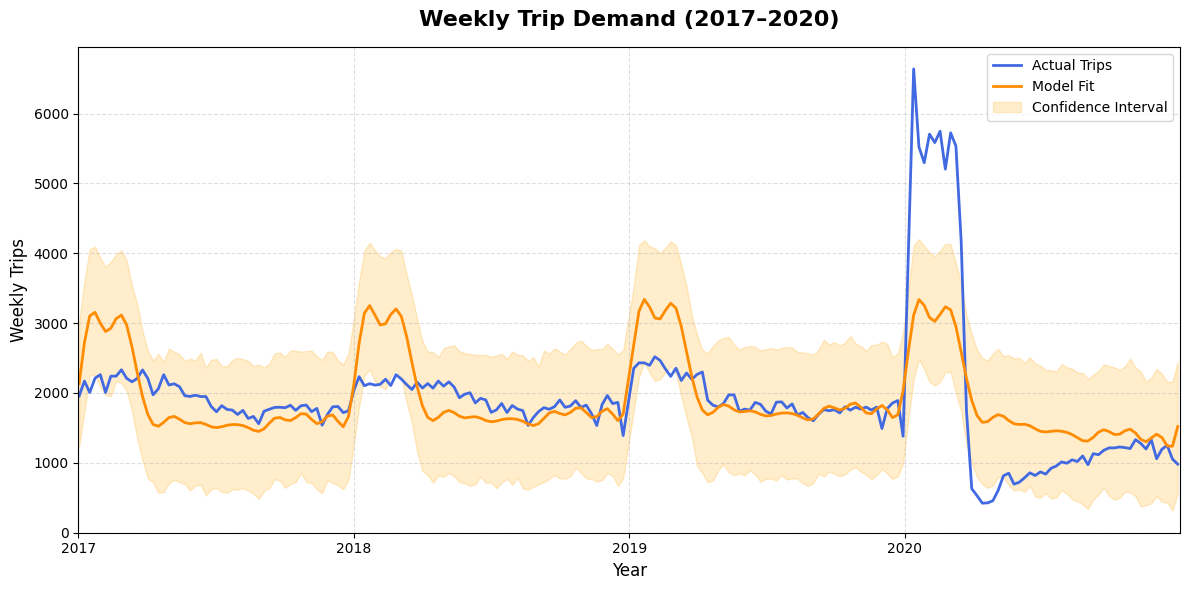

In [11]:
# --- Import libraries ---
from prophet import Prophet
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# --- Model training ---
model = Prophet()
model.fit(df_prophet)

# --- Forecast generation ---
future = model.make_future_dataframe(periods=12, freq='W')
forecast = model.predict(future)

# --- Filter only 2017–2020 range for display ---
forecast_filtered = forecast[
    (forecast['ds'] >= '2017-01-01') & (forecast['ds'] <= '2020-12-31')
]

# --- Plot ---
plt.figure(figsize=(12,6))

# Actual trips (blue)
plt.plot(df_prophet['ds'], df_prophet['y'], color='royalblue', label='Actual Trips', linewidth=2)

# Model fit (orange)
plt.plot(forecast_filtered['ds'], forecast_filtered['yhat'], color='darkorange', label='Model Fit', linewidth=2)

# Confidence interval
plt.fill_between(
    forecast_filtered['ds'],
    forecast_filtered['yhat_lower'],
    forecast_filtered['yhat_upper'],
    color='orange',
    alpha=0.2,
    label='Confidence Interval'
)

# --- Formatting ---
plt.title("Weekly Trip Demand (2017–2020)", fontsize=16, fontweight='bold', pad=15)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Weekly Trips", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)

# Show year ticks
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# ✅ Fix x-axis limit using datetime objects
plt.xlim(pd.Timestamp('2017-01-01'), pd.Timestamp('2020-12-31'))

plt.tight_layout()
plt.show()


<h2>Insight: The forecasting model successfully identifies recurring weekly demand cycles between 2017–2020. A moderate upward trend with seasonal variations is observed, and future projections suggest steady trip volumes with minimal volatility.</h2>


<h1>High Tip Prediction Model</h1>

In [4]:
df.columns.tolist()


['VendorID',
 'lpep_pickup_datetime',
 'lpep_dropoff_datetime',
 'store_and_fwd_flag',
 'RatecodeID',
 'PULocationID',
 'DOLocationID',
 'passenger_count',
 'trip_distance',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'payment_type',
 'trip_type',
 'congestion_surcharge']

In [5]:
# Convert pickup datetime if not already
df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'])

# Extract hour and day of week
df['hour'] = df['lpep_pickup_datetime'].dt.hour
df['day_of_week'] = df['lpep_pickup_datetime'].dt.day_name()

# Map boroughs using taxi_zones.csv
taxi_zones = pd.read_csv("trips/taxi_zones.csv")

# Merge pickup and dropoff boroughs
df = df.merge(taxi_zones[['LocationID', 'Borough']], left_on='PULocationID', right_on='LocationID', how='left')
df = df.rename(columns={'Borough': 'pickup_borough'})
df = df.drop(columns=['LocationID'])

df = df.merge(taxi_zones[['LocationID', 'Borough']], left_on='DOLocationID', right_on='LocationID', how='left')
df = df.rename(columns={'Borough': 'dropoff_borough'})
df = df.drop(columns=['LocationID'])


In [4]:
# Create binary column for High Tip
df['High_Tip'] = (df['tip_amount'] > df['tip_amount'].mean()).astype(int)

# Feature selection
features = ['trip_distance', 'fare_amount', 'pickup_borough', 'dropoff_borough', 'hour', 'day_of_week']

df_encoded = pd.get_dummies(df[features + ['High_Tip']], drop_first=True)

X = df_encoded.drop('High_Tip', axis=1)
y = df_encoded['High_Tip']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
rf = RandomForestClassifier(n_estimators=150, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("🎯 Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


🎯 Accuracy: 0.6306125

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.76      0.73     51727
           1       0.47      0.39      0.43     28273

    accuracy                           0.63     80000
   macro avg       0.58      0.58      0.58     80000
weighted avg       0.62      0.63      0.62     80000



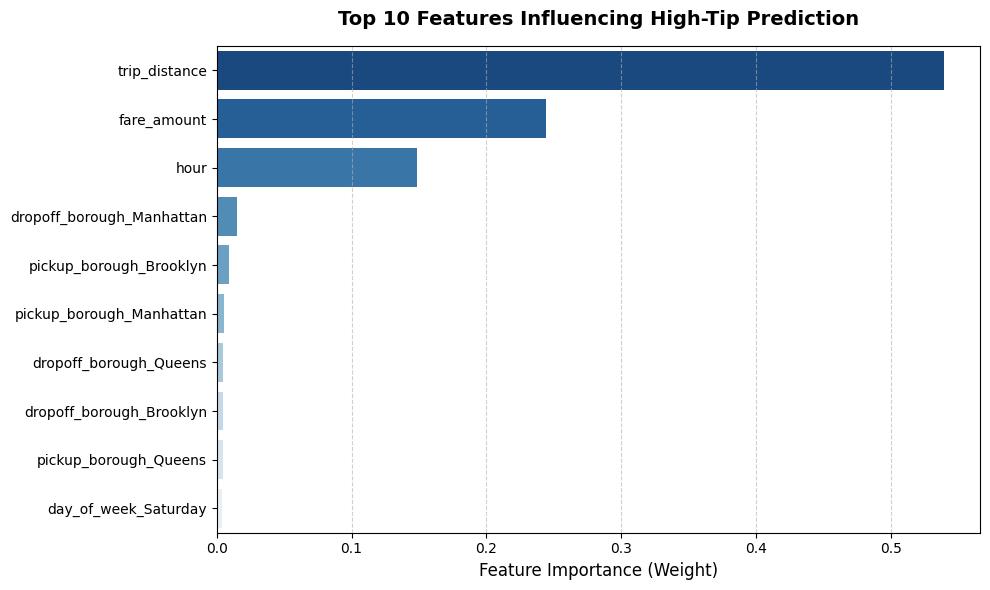

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Sort features by importance
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
features_list = X.columns

feat_imp_df = pd.DataFrame({
    'Feature': features_list[indices],
    'Importance': importances[indices]
})

plt.figure(figsize=(10,6))
sns.barplot(
    data=feat_imp_df.head(10),
    x='Importance',
    y='Feature',
    hue='Feature',
    dodge=False,
    legend=False,
    palette='Blues_r'
)

plt.title("Top 10 Features Influencing High-Tip Prediction", fontsize=14, weight='bold', pad=15)
plt.xlabel("Feature Importance (Weight)", fontsize=12)
plt.ylabel("")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


<h1>Route-Based Revenue Forecast</h1>

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# --- Step 1: Prepare dataset ---
# Keep only relevant years
df = df[(df['lpep_pickup_datetime'].dt.year >= 2017) & (df['lpep_pickup_datetime'].dt.year <= 2020)]

# Create route name
df['route'] = df['pickup_borough'] + " → " + df['dropoff_borough']

# Create month column
df['month'] = df['lpep_pickup_datetime'].dt.to_period('M').dt.to_timestamp()

# Aggregate revenue per route per month
monthly_route = df.groupby(['route', 'month']).agg(
    total_revenue=('total_amount', 'sum'),
    total_trips=('total_amount', 'count'),
    avg_fare=('fare_amount', 'mean'),
    avg_distance=('trip_distance', 'mean')
).reset_index()

print(monthly_route.head())


           route      month  total_revenue  total_trips   avg_fare  \
0  Bronx → Bronx 2017-01-01        2715.92          241   9.841909   
1  Bronx → Bronx 2017-02-01        2874.64          276   9.215580   
2  Bronx → Bronx 2017-03-01        4264.67          364  10.381319   
3  Bronx → Bronx 2017-04-01        3091.79          270  10.195556   
4  Bronx → Bronx 2017-05-01        2664.08          237   9.905105   

   avg_distance  
0      2.044689  
1      1.823007  
2      2.147418  
3      2.057407  
4      1.981983  


In [9]:
# Extract time features
monthly_route['year'] = monthly_route['month'].dt.year
monthly_route['month_num'] = monthly_route['month'].dt.month
monthly_route['is_year_start'] = monthly_route['month'].dt.is_year_start.astype(int)

# Sort for lag features
monthly_route = monthly_route.sort_values(['route', 'month'])

# Lag (previous month revenue) — helps model learn trends
monthly_route['prev_month_revenue'] = monthly_route.groupby('route')['total_revenue'].shift(1)
monthly_route['revenue_growth'] = (
    monthly_route['total_revenue'] - monthly_route['prev_month_revenue']
) / monthly_route['prev_month_revenue']

# Drop NaN from first months
monthly_route.dropna(inplace=True)


📊 Model Performance:
   • Mean Absolute Error (MAE): 14.31
   • R² Score: 0.98


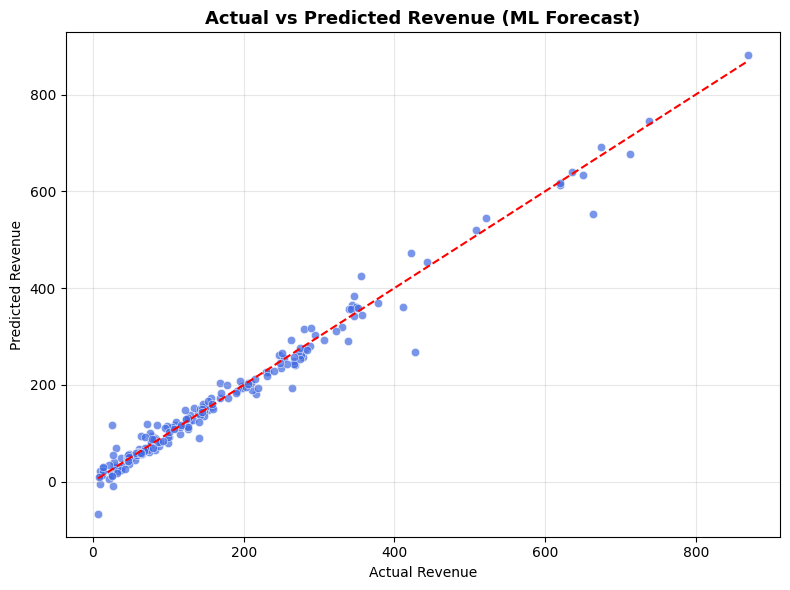

C:\Users\anshi\AppData\Local\Temp\ipykernel_16140\16477034.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


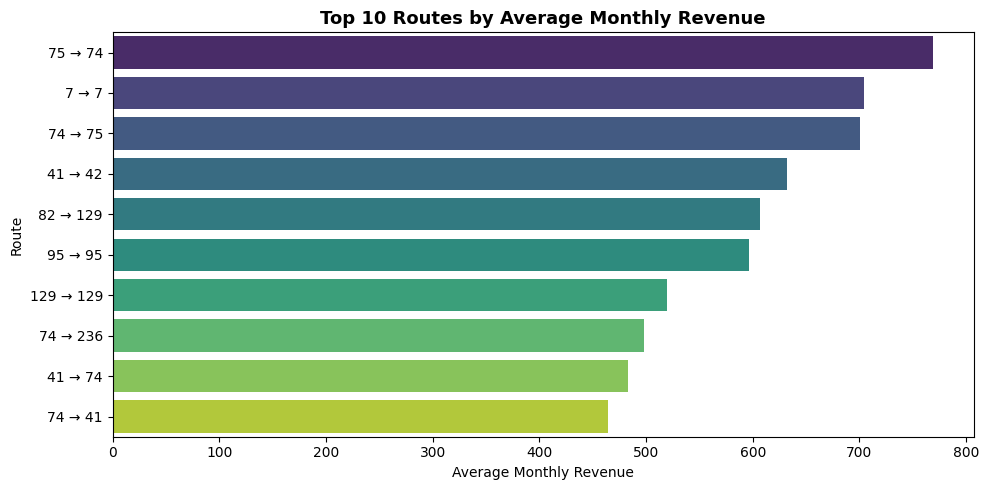


🚀 Top 10 Routes by Average Monthly Revenue:

    Route  Avg Monthly Revenue
  75 → 74           768.600833
    7 → 7           704.010208
  74 → 75           700.487500
  41 → 42           632.104792
 82 → 129           606.688542
  95 → 95           596.680208
129 → 129           519.283830
 74 → 236           498.486667
  41 → 74           483.401250
  74 → 41           464.172708


In [17]:

#  ROUTE-BASED REVENUE FORECASTING 


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score


# 1️ FEATURE SELECTION & ENCODING


# Features used for model training
features = [
    'total_trips', 'avg_fare', 'avg_distance',
    'year', 'month_num', 'is_year_start',
    'prev_month_revenue', 'revenue_growth'
]

# ✅ Ensure monthly_route exists
if 'monthly_route' not in locals():
    raise ValueError("monthly_route DataFrame not found. Please create it before running this code.")

# ✅ Select only Top 20 routes to avoid MemoryError from one-hot encoding
top_routes = monthly_route['route'].value_counts().head(20).index
monthly_route_small = monthly_route[monthly_route['route'].isin(top_routes)].copy()

# ✅ One-hot encode routes safely
monthly_route_encoded = pd.get_dummies(monthly_route_small, columns=['route'], drop_first=True)

# ✅ Build X and y
X = monthly_route_encoded[features + [col for col in monthly_route_encoded.columns if col.startswith('route_')]]
y = monthly_route_encoded['total_revenue']


# 2️ CLEAN FEATURE MATRIX SAFELY

X = X.copy()
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(0, inplace=True)
y = y.replace([np.inf, -np.inf], np.nan).fillna(0)


# 3️ TRAIN-TEST SPLIT & MODEL TRAINING

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

lr = LinearRegression()
lr.fit(X_train, y_train)

# Predictions
y_pred = lr.predict(X_test)


# 4️ EVALUATION

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("📊 Model Performance:")
print(f"   • Mean Absolute Error (MAE): {mae:.2f}")
print(f"   • R² Score: {r2:.2f}")


# 5️ VISUALIZATION: ACTUAL vs PREDICTED

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, color='royalblue', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Actual vs Predicted Revenue (ML Forecast)", fontsize=13, weight='bold')
plt.xlabel("Actual Revenue")
plt.ylabel("Predicted Revenue")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# 6️ TOP ROUTES BY AVERAGE REVENUE

# Calculate top 10 routes by average monthly revenue
top_revenue_routes = (
    monthly_route.groupby('route')['total_revenue']
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

# Convert to DataFrame for plotting
top_routes_df = top_revenue_routes.reset_index()
top_routes_df.columns = ['Route', 'Avg Monthly Revenue']

plt.figure(figsize=(10, 5))
sns.barplot(
    data=top_routes_df,
    x='Avg Monthly Revenue',
    y='Route',
    palette='viridis'
)
plt.title("Top 10 Routes by Average Monthly Revenue", fontsize=13, weight='bold')
plt.xlabel("Average Monthly Revenue")
plt.ylabel("Route")
plt.tight_layout()
plt.show()

print("\n🚀 Top 10 Routes by Average Monthly Revenue:\n")
print(top_routes_df.to_string(index=False))
